# Feature Training Experiments

In this notebook we analyse results obtained from the training sets experiments. The experimental design is as follows:

2. Let $m$ represent the machine learning model where $m$ $\in$ `["ADA", "LR", "DT", "RF"]`
3. Let $full$, $train$ and $test$ represent the full, training & testing subsets respectively. $train$ and $test$ are $0.75$ and $0.25$ of $full$ respectively
4. Let $train_{n}$ be sub-subsets of the training subset where `n` $\in$ `[0.1, 1.0]` representing the fraction of the data used
5. Let $m\prime_{n}$ be the model trained using $train_{n}$
6. Let $\hat{y}_{n, m\prime}$ be the predictions obtained from $m\prime_{n}$ on $test$. **Note that unlike the feature sets experiment, we use the same testing data here**
7. Let $d$ represent the group fairness metric where $d$ $\in$ `["DI", "SPD"]`
7. Let $v_{train, n, d}$ be data fairness metrics calculated using $train_{n}$. **Note that we do not compute fairness metrics from both subsets, because in this experiment the test subset remains unchanged**
1. Let $v_{n, m\prime, d}$ be the model fairness metrics calculated using $\hat{y}_{n, m\prime}$
1. We can reduce the granularity a bit for the analysis by considering the fairness metrics across the sub-subsets. Let $v_{train, d}$ and $v_{m\prime, d}$ represent the fairness metrics across the sub-subsets.

The objective is to analyse the following:
2. Relationship between $v_{train, d}$ and $v_{m\prime, d}$

Our hypothesis is that $v_{train, d}$ and $v_{m\prime, d}$ have some form of relationship. Another way of formulating the above statement is that the two random variables have similar distribution.

We employ two types of tests to verify our hypothesis:
1. Correlation and
2. Linear regression

In [1]:
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from scipy.stats import shapiro, chi2
from sklearn.linear_model import LinearRegression

ROOTDIR = os.path.abspath(os.path.join(os.getcwd(), ".."))
DATADIR = os.path.join(ROOTDIR, "data")
sys.path.insert(0, ROOTDIR)


In [2]:
import glob
from src.data import process

batch1 = [pd.read_csv(frame) for frame in glob.glob(os.path.join(DATADIR, "exp-training-sets-*-25.csv"))]
batch2 = [pd.read_csv(frame) for frame in glob.glob(os.path.join(DATADIR, "exp-training-sets-*-25-2.csv"))]

batch1 = pd.concat(batch1)
batch2 = pd.concat(batch2)

# we need to reset the `iteration` column for the second batch
# since we use this column as the index when calculating the
# correlation (see correlation cell below) & we cannot have
# duplicates in this column
batch2["iteration"] = batch2["iteration"] + 25
data = pd.concat([batch1, batch2])
data.shape

(60000, 25)

In [3]:
# preprocessing the data prior to analysis
# 1. fairness metrics are only calculated when privileged == None
# 2. scale fairness metrics according to zhang2021ignorance paper
# 3. combine dataset_label & protected
# 4. set the index to iteration
# 4. drop unused columns
# 4. rename column names
# 4. rename model names
data = data[data["privileged"] == "None"]
process(data)
data["dataset_label"] = data["dataset_label"] + "-" + data["protected"].str.lower()
data = data.rename(columns={
    "dataset_label": "dataset",
    "disparate_impact": "DI",
    "statistical_parity_difference": "SPD",
})
data = data.set_index("iteration")
data = data[[
    "DI",
    "SPD",
    "frac",
    "model",
    "dataset",
]]
data.loc[(data["model"] == "logisticregression"), "model"] = "LR"
data.loc[(data["model"] == "randomforestclassifier"), "model"] = "RF"
data.loc[(data["model"] == "adaboostclassifier"), "model"] = "ADA"
data.loc[(data["model"] == "decisiontreeclassifier"), "model"] = "DT"

data.shape

(20000, 5)

In [4]:
data.dtypes

DI         float64
SPD        float64
frac       float64
model       object
dataset     object
dtype: object

## Data validation

In this section I am performing some data quality checks to ensure that the data collection scripts worked as expected.

In [4]:
# here I am checking that we have data for the correct number of sub-subsets of the training set.

data.frac.unique()

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [5]:
# in this cell I am doing some manual checks to make
# sure I am sampling the data correctly by checking
# the shape of the dataset

# each vector should contain num_features*50 points

datasets = data["dataset"].unique().tolist()
models = data["model"].unique().tolist()
models.remove("None")

for dataset in datasets:
    _ = data[
        (data["dataset"] == dataset) &
        (data["model"] == "None")
    ]
    assert _.shape[0] == len(_["frac"].unique().tolist())*50


    for model in models:
        _ = data[
            (data["dataset"] == dataset) &
            (data["model"] == model)
        ]
    assert _.shape[0] == len(_["frac"].unique().tolist())*50

# Shapiro-wilk test for normality
In this section we employ the Shapiro-Wilk test for normality. The test is as follows:

- $H_o$: the population is normally distributed
- $H_1$: the population is not normally distributed

We need to test for normality since statistical analysis & formuli used later in the analysis will depend on normality assumption.

In [6]:
pvalues = {
    "dataset": [],
    "model": [],
    "DI": [],
    "SPD": [],
}

for dataset in datasets:
    _ = data[
        (data["dataset"] == dataset) &
        (data["model"] == "None")
    ]
    pvalues["dataset"].append(dataset)
    pvalues["model"].append("None")
    pvalues["DI"].append(shapiro(_["DI"]).pvalue)
    pvalues["SPD"].append(shapiro(_["SPD"]).pvalue)

    for model in models:
        _ = data[
            (data["dataset"] == dataset) &
            (data["model"] == model)
        ]
        pvalues["dataset"].append(dataset)
        pvalues["model"].append(model)
        pvalues["DI"].append(shapiro(_["DI"]).pvalue)
        pvalues["SPD"].append(shapiro(_["SPD"]).pvalue)

pvalues = pd.DataFrame(data=pvalues)
pvalues["DI"] = pvalues["DI"].apply(
    lambda x: "".join(["*" for t in [0.01, 0.05, 0.1] if x<=t])
)
pvalues["SPD"] = pvalues["SPD"].apply(
    lambda x: "".join(["*" for t in [0.01, 0.05, 0.1] if x<=t])
)
pvalues


,dataset,model,DI,SPD
0,adult-sex,None,***,***
1,adult-sex,LR,***,***
2,adult-sex,DT,,**
3,adult-sex,ADA,***,***
4,adult-sex,RF,***,***
5,bank-age,None,***,***
6,bank-age,LR,*,
7,bank-age,DT,,
8,bank-age,ADA,***,***
9,bank-age,RF,,


# Distributional Analysis
In this section we analyse the distribution of the fairness metrics. We employ the following methods:

2. Distribution of the data fairness metrics (and model fairness metrics) within each $frac$
3. Distribtion of the data fairness metrics (and model fairness metrics) across each $frac$

We limit our analysis first to the adult-sex dataset.

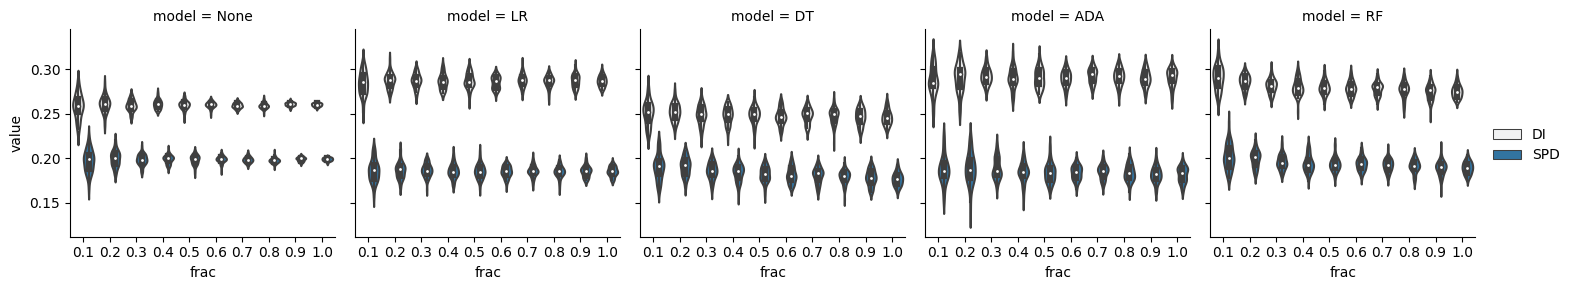

In [54]:
id_vars = ["frac", "model", "dataset"]
# violinplots in this setting are not that useful, use boxplots instead
_ = data[
    (data["dataset"] == "adult-sex")
]
g = sns.FacetGrid(
    data=_.melt(id_vars=id_vars),
    col="model",
)
g.map_dataframe(
    sns.violinplot,
    x="frac",
    y="value",
    hue="variable",
)
g.add_legend()

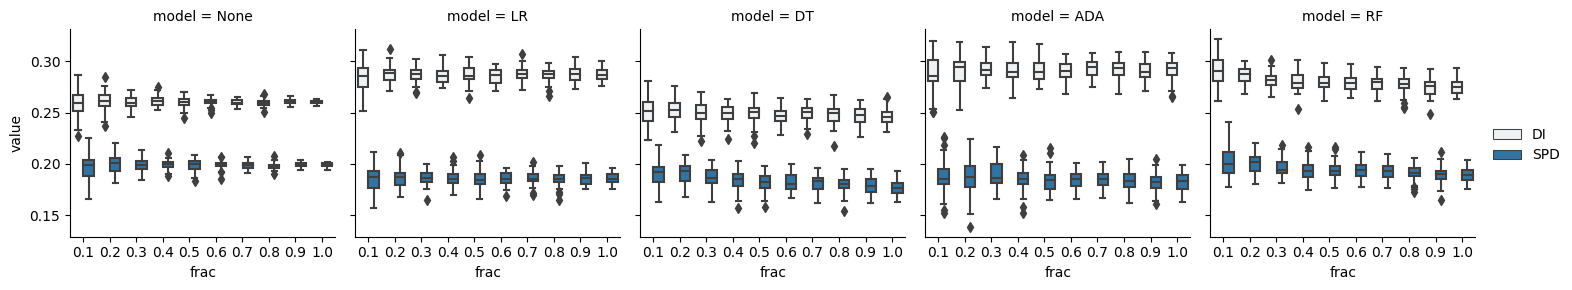

In [11]:
_ = data[
    (data["dataset"] == "adult-sex")
]
g = sns.FacetGrid(
    data=_.melt(id_vars=id_vars),
    col="model",
)
g.map_dataframe(
    sns.boxplot,
    x="frac",
    y="value",
    hue="variable",
)
g.add_legend()

The spread of the box/violin plots reduce as we increase the frac size. This could be because the variability of the sub-subset reduces as we increase the frac size. For instance, when $frac=0.1$, we are more likely to have different examples in each of our 50 iterations. This reduces as we increase the frac size.

# Relational analysis
In this section we analyse relationship between our features. In particular:

1. Relationship between DFM (and MFM) wrt frac
2. Relationship between DI & SPD

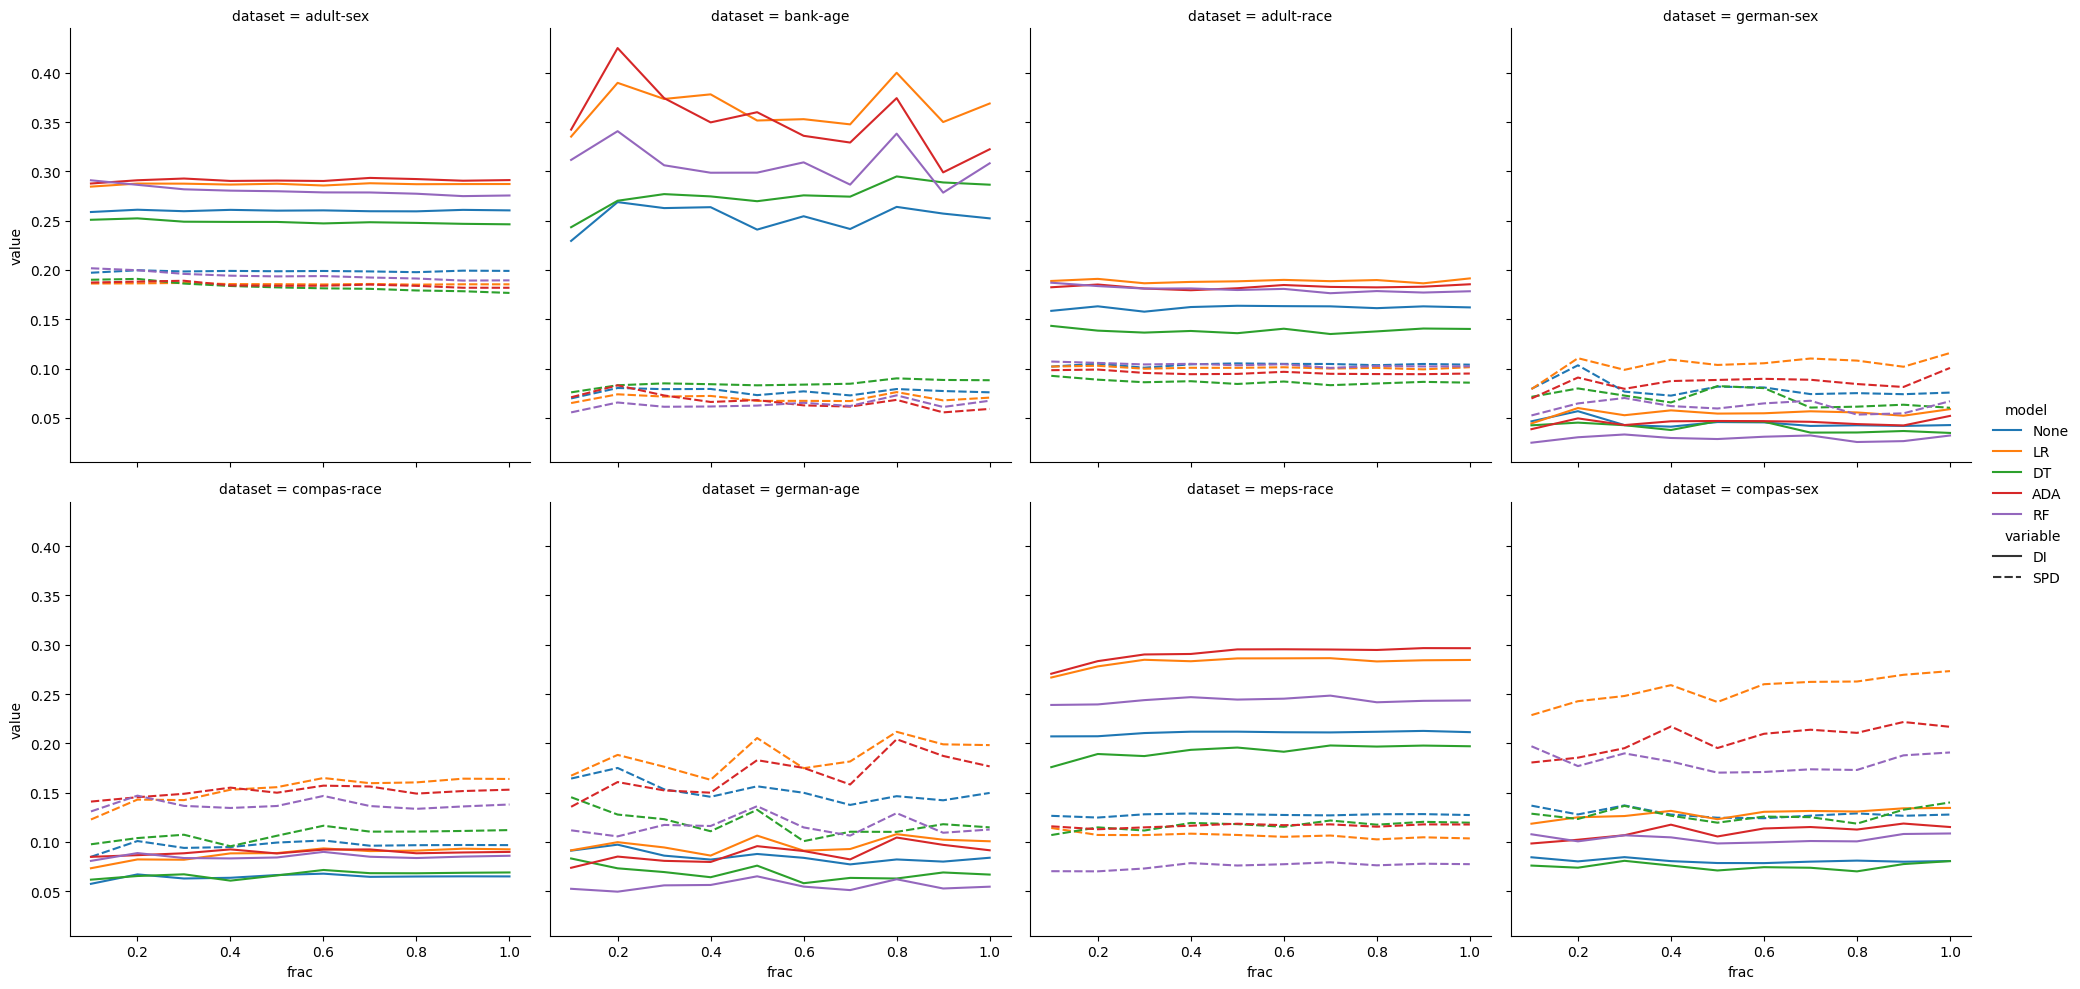

In [13]:
sns.relplot(
    kind="line",
    data=data.melt(id_vars=id_vars),
    x="frac",
    y="value",
    hue="model",
    style="variable",
    col="dataset",
    col_wrap=4,
    errorbar=None,
)

zhang2021ignorance reports that increase in training size has a negative impact on fairness (which is difficult to validate visually for all datasets). Can we replicate their results by calculating the absolute & relative changes?

DT is more fair than the DFM, meaning that the model is "learning" and making fairer decisions. It will be interesting to see how the fairness metrics & the performance metrics compare to one another. Is DT able to perform well & make fair predictions?

In most cases, DT has the lowest values (meaning it is more fair), sometimes it is even better than DFM! Can we perhaps prioritise fairness testing with DT? For instance, if DT model is giving unfair predictions, we can guarantee that other models will have worse fairness?

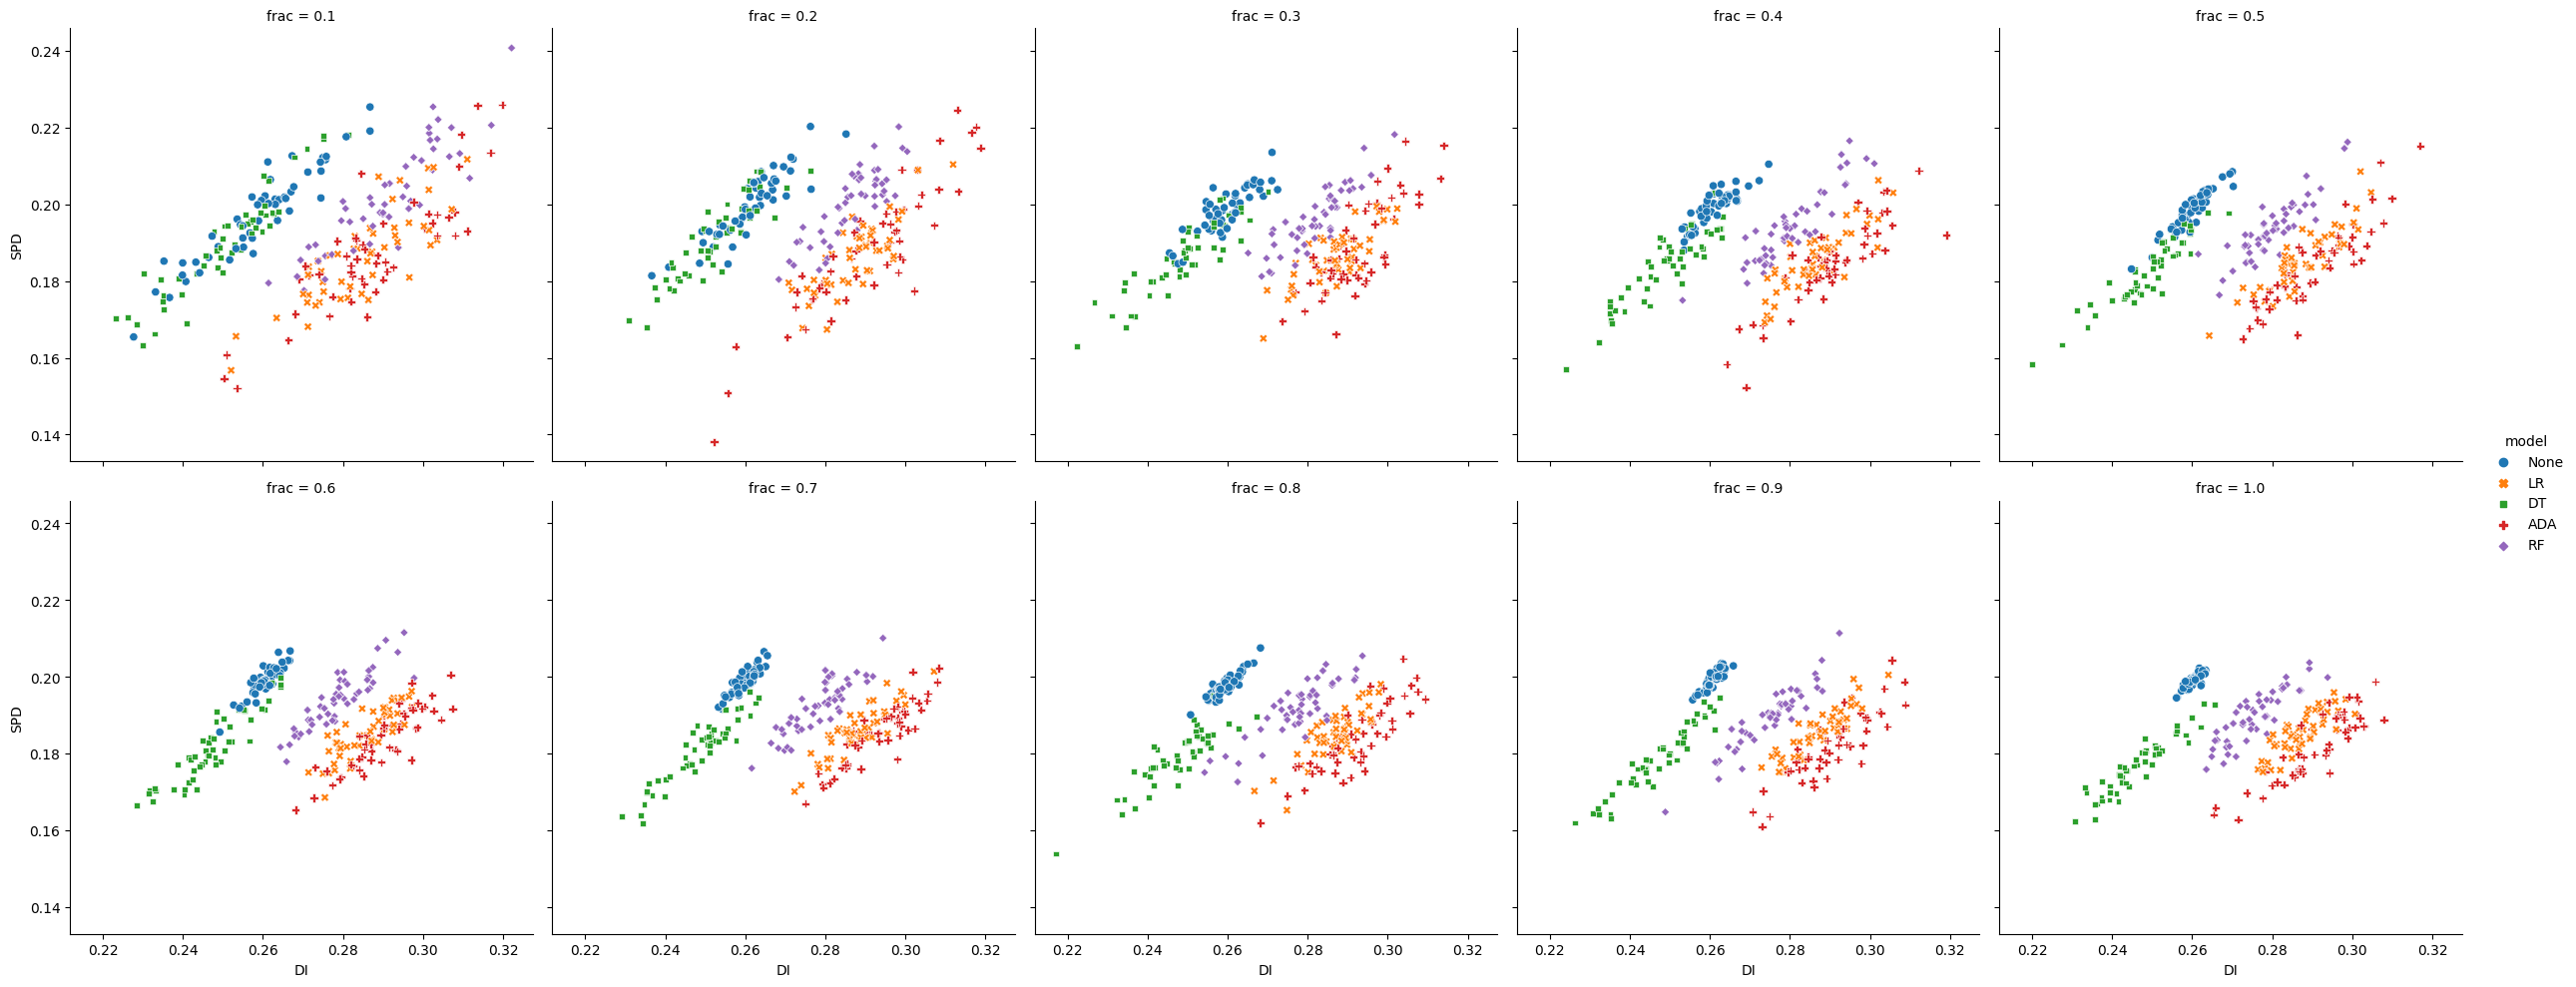

In [18]:
sns.relplot(
    data=data[data["dataset"] == "adult-sex"],
    x="DI",
    y="SPD",
    hue="model",
    style="model",
    col="frac",
    col_wrap=5,
)

There is a linear relationship between DI & SPD.

Can we propose a minimisation in terms of the fairness metrics to use? For instance, is DI more sensitive to fairness issues in a dataset? Can we provide a statistical guarantee that if DI indicates fairness issue we don't need to check with other metrics?

Can we perform a paired-t test to determine if DI & SPD have similar underlying distribution? Is that a good enough statistical test?

Limitations: we only tested with 2 group fairness metrics, there are several in reality.

# Fairness metric minimization
In this section we employ two tests, namely correlation & linear regression to validate if testing for fairness using only the data is enough.

## Correlation
In this section we employ correlation to test if there is a relationship between the data & model metrics. From the section above, we note that the distribution of the populations are not normal.

We use the Spearman's correlation since it does not assume normality & is robust to outliers.

We also need to check the significance of the correlation by observing the pvalues of the correlations. If the pvalue is greater than 0.05 then the observed correlation is not by chance. From `scipy.stats.speakmanr` docs:

- $H_o$: the variables are uncorrelated
- $H_1$: the variables have a two-sided correlation (default value of `alternative` argument is `"two-sided"`)

In [40]:
from scipy.stats import spearmanr

indices = [[
    "DI",
    "SPD",
],
models]
corr = pd.DataFrame(columns=datasets, index=pd.MultiIndex.from_product(
    indices, names=["metric", "model"]
))
corr_pvalues = pd.DataFrame(columns=datasets, index=pd.MultiIndex.from_product(
    indices, names=["metric", "model"]
))

for d in datasets:
    _ = data[
        (data["dataset"] == d)
    ]
    for metric in ["DI", "SPD"]:
        _pivots = []
        for n in _["frac"].unique().tolist():
            _pivots.append(pd.pivot(
                data=_[_["frac"] == n],
                columns="model",
                values=metric,
            ))
        pivoted = pd.concat(_pivots)
        for model in models:
            c, p = spearmanr(pivoted[model], pivoted["None"])
            corr.loc[(metric, model), d] = c
            corr_pvalues.loc[(metric, model), d] = p

corr

adult-sex  bank-age adult-race german-sex compas-race german-age  \
metric model                                                                    
DI     LR     0.167482  0.161118    0.22982   0.259774    0.610876   0.377366   
       DT     0.120302  0.026361  -0.025248   0.117561    0.315603   0.178152   
       ADA    0.149729  0.160217   0.196631   0.278018    0.172046   0.354511   
       RF     0.093628  0.095935    0.03629   0.113319    0.435218   0.338088   
SPD    LR     0.166608  0.167229   0.235562   0.261476    0.614609   0.372273   
       DT     0.102946  0.023587   -0.02215   0.115536     0.31473   0.183284   
       ADA    0.175828  0.164544   0.208509   0.282799    0.186405   0.350386   
       RF     0.116142  0.099711   0.066648   0.114784    0.438884   0.327624   

             meps-race compas-sex  
metric model                       
DI     LR     0.251478   0.494765  
       DT      0.20719    0.36158  
       ADA    0.234448   0.341801  
       RF     0.106394    0.43341  
SPD    LR     0.245424   0.496653  
       DT     0.195862   0.356129  
       ADA    0.273801   0.343258  
       RF     0.165151    0.43605

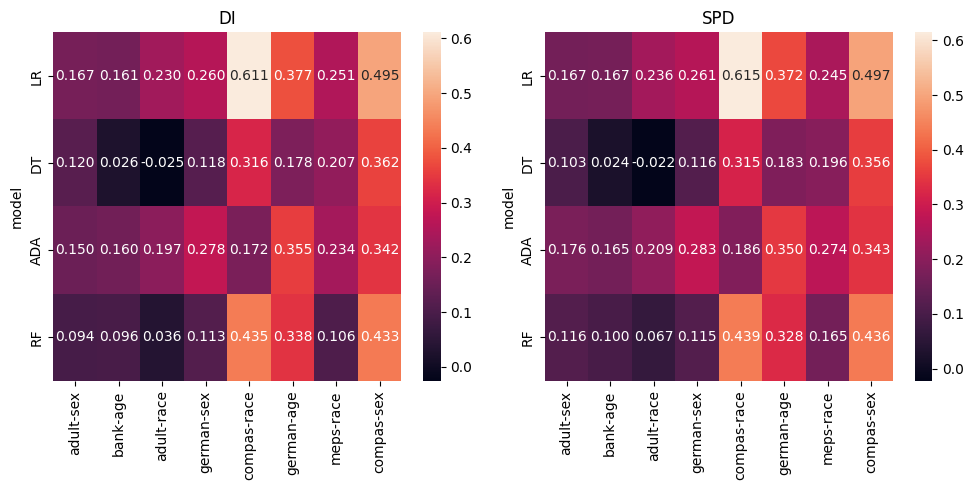

In [41]:
fig, axs = plt.subplots(
    nrows=1,
    ncols=2,
    figsize=(10, 5)
)

ax = axs[0]
ax.set_title("DI")
ax.set_ylabel(None)
ax.set_xlabel(None)
sns.heatmap(
    data=corr.loc["DI", :].astype(float),
    annot=True,
    fmt=".3f",
    ax=ax
)

ax = axs[1]
ax.set_title("SPD")
ax.set_ylabel(None)
ax.set_xlabel(None)
sns.heatmap(
    data=corr.loc["SPD", :].astype(float),
    annot=True,
    fmt=".3f",
    ax=ax
)

fig.tight_layout()

Lets observe the pvalues next. It is difficult to process just the raw numbers, thus we represent the pvalues as asterisks where more number of asterisks represents a lower pvalue.

In [42]:
corr_pvalues.applymap(
    lambda x: ''.join(['*' for t in [0.01,0.05,0.1] if x<=t])
)

adult-sex bank-age adult-race german-sex compas-race german-age  \
metric model                                                                   
DI     LR          ***      ***        ***        ***         ***        ***   
       DT          ***                            ***         ***        ***   
       ADA         ***      ***        ***        ***         ***        ***   
       RF           **       **                    **         ***        ***   
SPD    LR          ***      ***        ***        ***         ***        ***   
       DT           **                            ***         ***        ***   
       ADA         ***      ***        ***        ***         ***        ***   
       RF          ***       **                    **         ***        ***   

             meps-race compas-sex  
metric model                       
DI     LR          ***        ***  
       DT          ***        ***  
       ADA         ***        ***  
       RF           **        ***  
SPD    LR          ***        ***  
       DT          ***        ***  
       ADA         ***        ***  
       RF          ***        ***

Lets observe how the correlation changes across various fracs next.

In [57]:
d = {
    "metric": [],
    "frac": [],
    "corr": [],
    "model": [],
    "dataset": [],
}

for dataset in datasets:
    _ = data[data["dataset"] == dataset]
    for metric in ["DI", "SPD"]:
        for n in _["frac"].unique().tolist():
            pivot = pd.pivot(
                data=_[_["frac"] == n],
                columns="model",
                values=metric,
            )
            for model in models:
                c, p = spearmanr(pivot[model], pivot["None"])
                d["metric"].append(metric)
                d["frac"].append(n)
                d["corr"].append(c)
                d["model"].append(model)
                d["dataset"].append(dataset)

corr = pd.DataFrame(data=d)
corr

,metric,frac,corr,model,dataset
0,DI,0.1,0.538439,LR,adult-sex
1,DI,0.1,0.415990,DT,adult-sex
2,DI,0.1,0.446915,ADA,adult-sex
3,DI,0.1,0.623049,RF,adult-sex
4,DI,0.2,0.260792,LR,adult-sex
...,...,...,...,...,...
635,SPD,0.9,0.058631,RF,compas-sex
636,SPD,1.0,0.372485,LR,compas-sex
637,SPD,1.0,0.010612,DT,compas-sex
638,SPD,1.0,0.141609,ADA,compas-sex


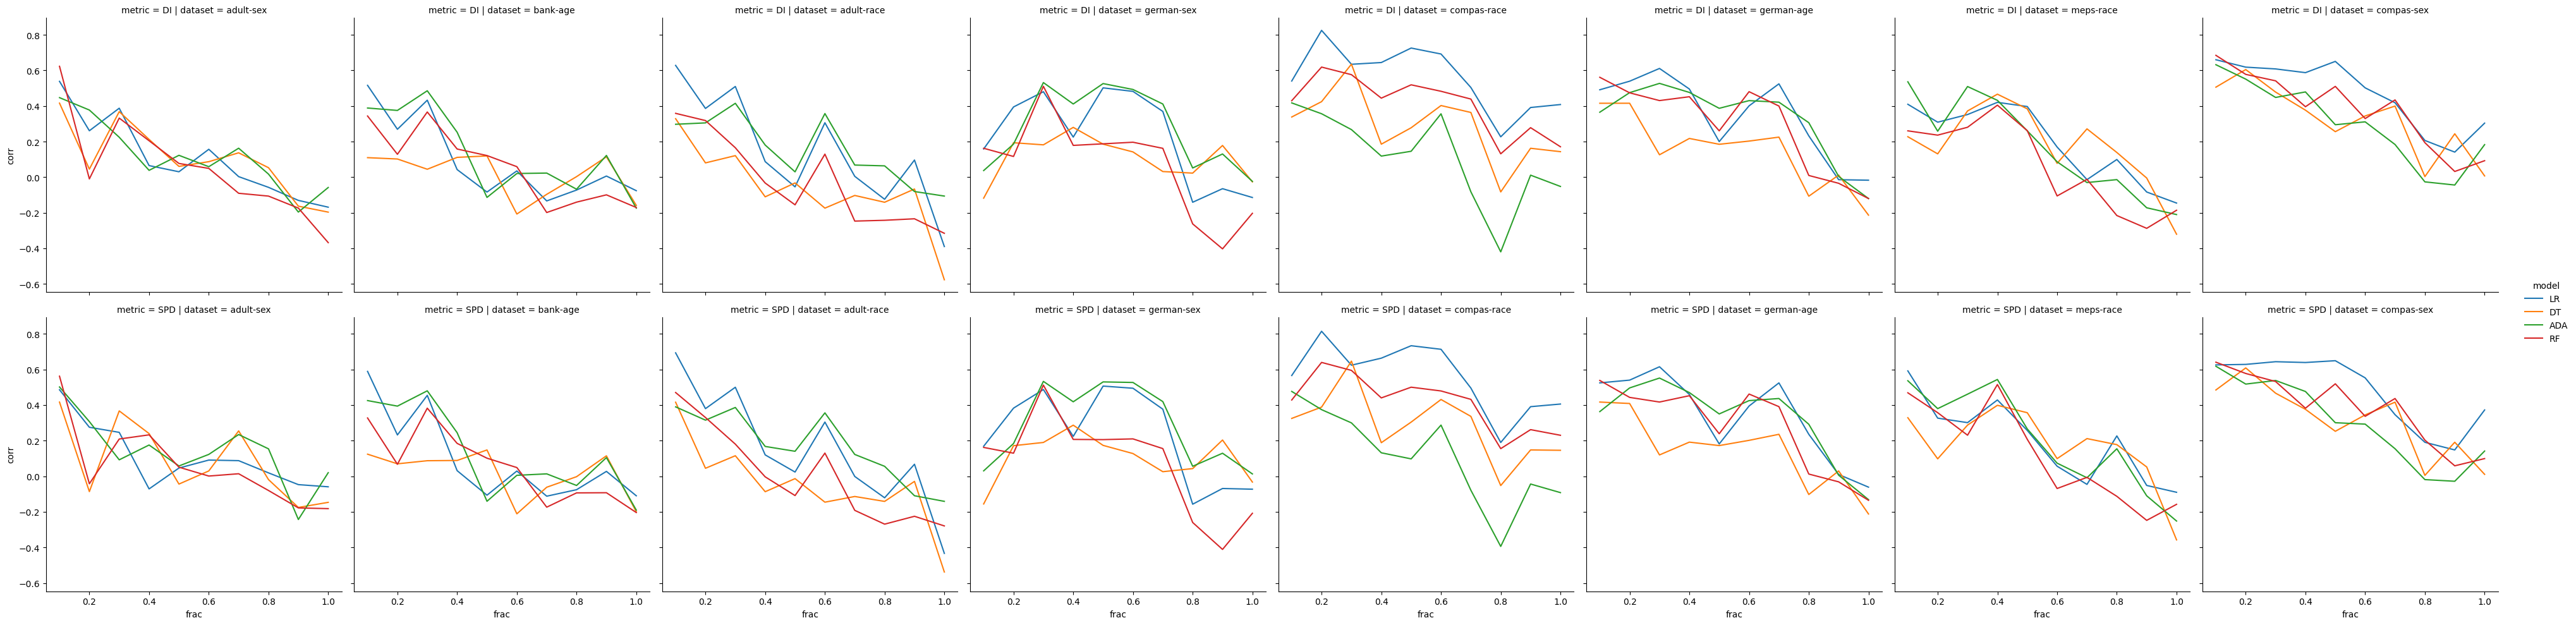

In [62]:
sns.relplot(
    kind="line",
    data=corr,
    hue="model",
    x="frac",
    y="corr",
    errorbar=None,
    row="metric",
    col="dataset",
)

## Linear Regression
In this section we employ linear regression to analyse relationship between the data & model fairness metrics.

We collect the following metrics:

1. min, max & avg for $v_{train, d}$
2. min, max & avg for $v_{m\prime, d}$
3. coefficient(slope) of the linear regression model
3. determination coefficient ($R^2$), a measure for "goodness-of-fit"

In [98]:

d = {
    "dataset": [],
    "model": [],
    "metric": [],
    "x_min": [],
    "x_max": [],
    "x_mean": [],
    "y_min": [],
    "y_max": [],
    "y_mean": [],
    "slope": [],
    "r2": [],
    "f_pvalue": [],
}

for dataset in datasets:
    for model in models:
        for metric in ["DI", "SPD"]:
            x = data[
                (data["dataset"] == dataset) &
                (data["model"] == "None")
            ][metric]
            y = data[
                (data["dataset"] == dataset) &
                (data["model"] == model)
            ][metric]
            mod = sm.OLS(
                endog=y.values.reshape(-1, 1),
                exog=x.values.reshape(-1, 1),
            )
            res = mod.fit()

            d["dataset"].append(dataset)
            d["model"].append(model)
            d["metric"].append(metric)
            d["x_min"].append(x.min())
            d["x_max"].append(x.max())
            d["x_mean"].append(x.mean())
            d["y_min"].append(y.min())
            d["y_max"].append(y.max())
            d["y_mean"].append(y.mean())
            d["slope"].append(res.params[0])
            d["r2"].append(res.rsquared)
            d["f_pvalue"].append(res.f_pvalue)

reg = pd.DataFrame(data=d)
reg


,dataset,model,metric,x_min,x_max,x_mean,y_min,y_max,y_mean,slope,r2,f_pvalue
0,adult-sex,LR,DI,0.227684,0.286748,0.260192,0.252034,0.311926,0.286918,1.102270,0.998948,0.000000e+00
1,adult-sex,LR,SPD,0.165432,0.225380,0.198702,0.156736,0.211731,0.185819,0.934616,0.998065,0.000000e+00
2,adult-sex,DT,DI,0.227684,0.286748,0.260192,0.217047,0.281327,0.248657,0.955295,0.998260,0.000000e+00
3,adult-sex,DT,SPD,0.165432,0.225380,0.198702,0.153843,0.218185,0.183014,0.920450,0.996471,0.000000e+00
4,adult-sex,ADA,DI,0.227684,0.286748,0.260192,0.250284,0.319748,0.291045,1.118167,0.998369,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...
59,compas-sex,DT,SPD,0.043651,0.265342,0.128725,0.011213,0.311251,0.127603,0.978541,0.906347,9.314859e-259
60,compas-sex,ADA,DI,0.030613,0.148758,0.080771,0.038954,0.171558,0.110479,1.349133,0.952181,0.000000e+00
61,compas-sex,ADA,SPD,0.043651,0.265342,0.128725,0.060277,0.351928,0.204544,1.558118,0.936150,2.851518e-300
62,compas-sex,RF,DI,0.030613,0.148758,0.080771,0.023510,0.189868,0.103505,1.266634,0.967728,0.000000e+00


<AxesSubplot: title={'center': 'SPD'}>

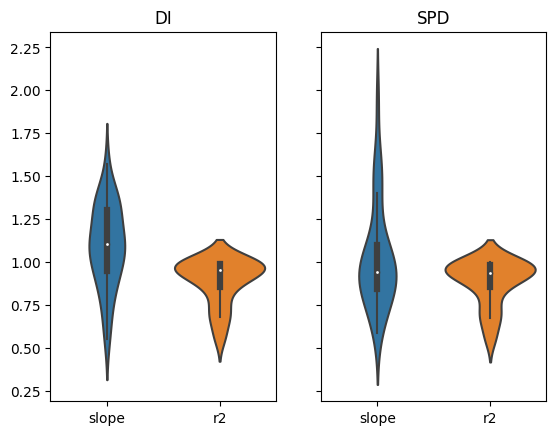

In [110]:
fig, axs = plt.subplots(
    nrows=1,
    ncols=2,
    sharey=True,
)

ax = axs[0]
ax.set_title("DI")
sns.violinplot(
    data=reg.loc[(reg["metric"] == "DI"), ["slope", "r2"]],
    ax=ax,
)

ax = axs[1]
ax.set_title("SPD")
sns.violinplot(
    data=reg.loc[(reg["metric"] == "SPD"), ["slope", "r2"]],
    ax=ax,
)

<AxesSubplot: title={'center': 'SPD'}>

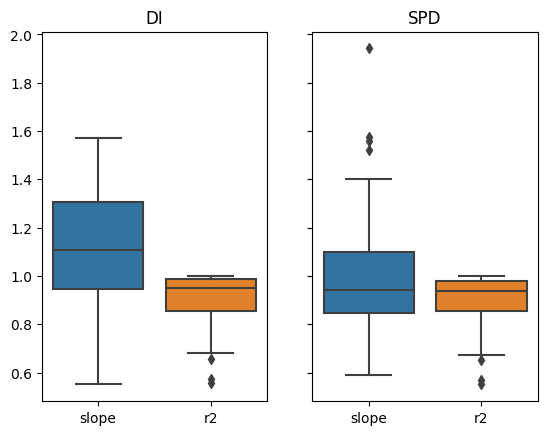

In [111]:
fig, axs = plt.subplots(
    nrows=1,
    ncols=2,
    sharey=True,
)

ax = axs[0]
ax.set_title("DI")
sns.boxplot(
    data=reg.loc[(reg["metric"] == "DI"), ["slope", "r2"]],
    ax=ax,
)

ax = axs[1]
ax.set_title("SPD")
sns.boxplot(
    data=reg.loc[(reg["metric"] == "SPD"), ["slope", "r2"]],
    ax=ax,
)

Most of the sloeps are positive & the determination coefficient ($R^2$) is close to 1 in majority. This indicates that the model is a good fit.